## Camera Calibration

The code for this section is in `./calibrate.py`, with `collect_obj_img_pts` as the entry point for this module.

The first step in the function is to prepare object points. Assuming that these points are fixed on the (x, y) plane, and that they're the same for each calibration image, the points are just a replicated array of coordinates, added for each image with detected corners.

The next step iterates through a given set of image paths, reads and grayscales the images, and looks for chessboard corners. If detected, the object points prepped above are appended to the `obj_pts` collector, and corners are appended to the `img_pts` collector.

See code below.

In [1]:
import glob
import calibrate

calib_img_paths = glob.glob('./camera_cal/*.jpg')
obj_pts, img_pts = calibrate.collect_obj_img_pts(calib_img_paths)

The next step is to get camera calibration matrix and distortion coefficents from `obj_pts` and `img_pts`, and apply the distortion correction to a test image.

This is done using the thin `calibrate_camera` and `undistort` wrapper functions.

In [2]:
# Helper graph functions
import matplotlib.pyplot as plt

%matplotlib inline

def double_plt(image_1, title_1, image_2, title_2):
    """Shortcut to show two images side by side"""
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(image_1, cmap='gray')
    ax1.set_title(title_1, fontsize=50)

    ax2.imshow(image_2, cmap='gray')
    ax2.set_title(title_2, fontsize=50)

    plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0)

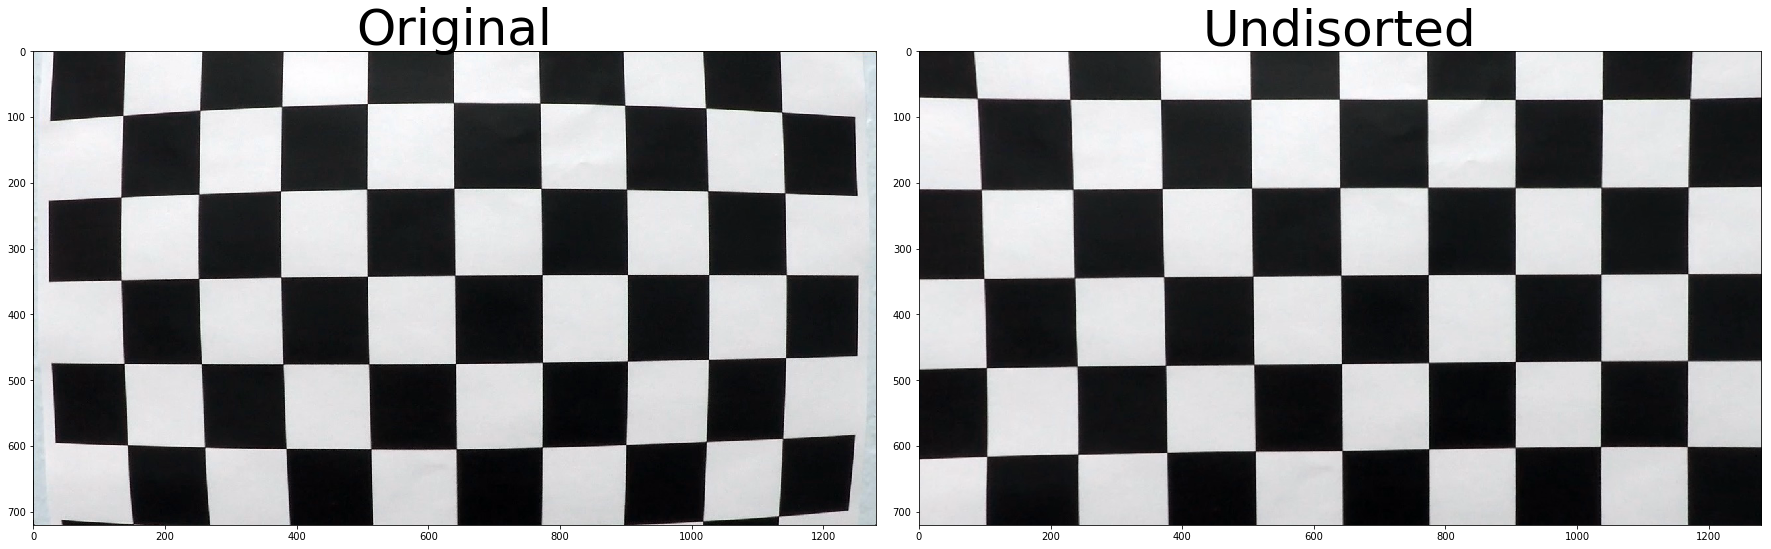

In [3]:
import cv2

# Get test image and its shape
test_image = cv2.imread('./camera_cal/calibration1.jpg')
img_size = tuple(reversed(test_image.shape[0:2]))

# Calibrate camera, undistort image
_, mtx, dist, _, _ = calibrate.calibrate_camera(
    obj_pts, img_pts, img_size
)
undistort = calibrate.undistort(test_image, mtx, dist)

double_plt(
    image_1=test_image, title_1='Original',
    image_2=undistort, title_2='Undisorted'    
)

## Pipeline (Images)

### 1. Distortion Correction

Here is an example of distortion correction on one of the test images.

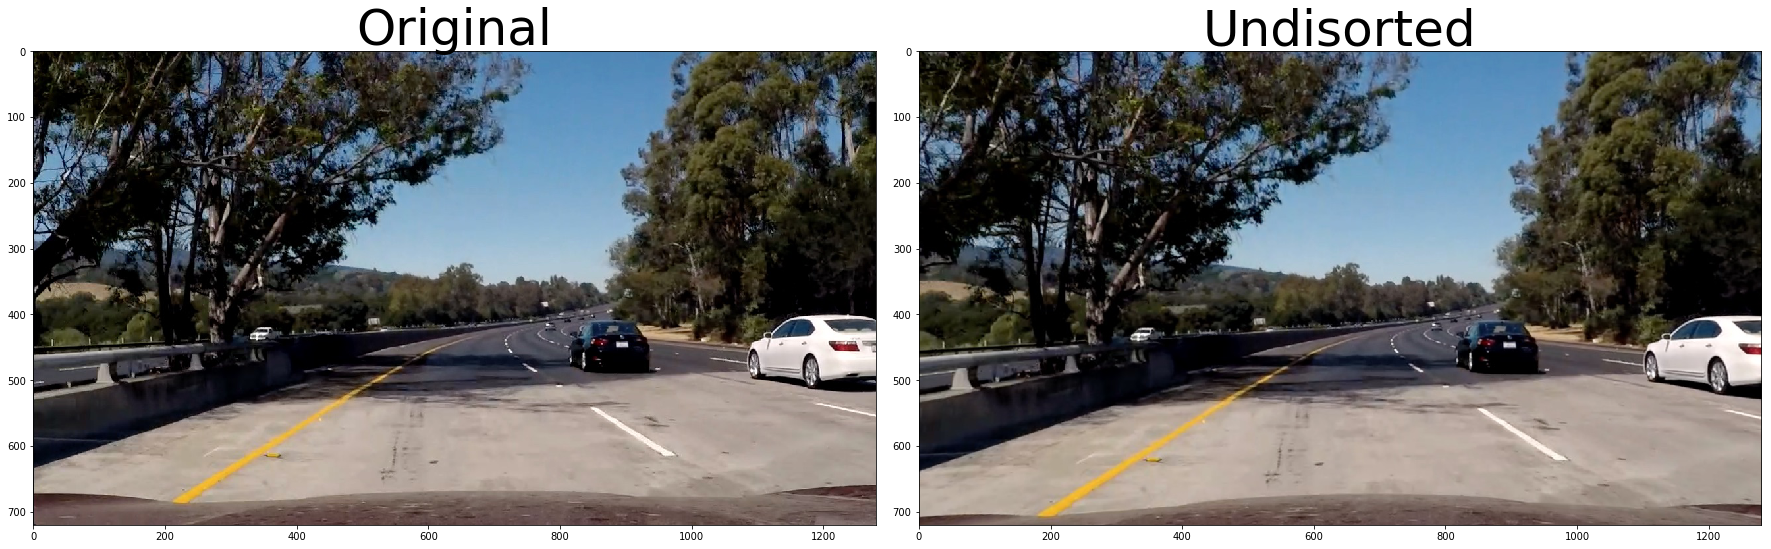

In [4]:
# Get test image and its shape

# Get test image and its shape
test_image = cv2.imread('./test_images/test5.jpg')
img_size = tuple(reversed(test_image.shape[0:2]))

# Calibrate camera, undistort image
_, mtx, dist, _, _ = calibrate.calibrate_camera(
    obj_pts, img_pts, img_size
)
undistort = calibrate.undistort(test_image, mtx, dist)

double_plt(
    image_1=cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB),
    title_1='Original',
    image_2=cv2.cvtColor(undistort, cv2.COLOR_BGR2RGB), 
    title_2='Undisorted'    
)

### 2. Binary Image

I experimented with both color spaces and various Sobel operators, but ended up using a combination of HLS thresholding, magnitude gradient thresholding, and direction gradient thresholding.

After several iterations, I decided to combine the three filters by assigning a positive value if two of the three filters are positive. Each of the filters were good at different things. Requiring a consensus was too restrictive, and allowing any one filter to determine the threshold was too permissive.

Some of the strengths/weaknesses of the three filters:

* HLS filter on saturation is generally the best at picking up both lanes, but can send false signals if the frame has shadows or unexpected light.


* Magnitude filter can pick up contrast a little better than HLS filter, but can be a bit noisy.


* Direction filter is extremely noisy, but is useful in filtering down the other two filter to line angles that can actually be lane lines.

See below for the parameters used and the resulting binaries. The code for this section is in `binary.py`.

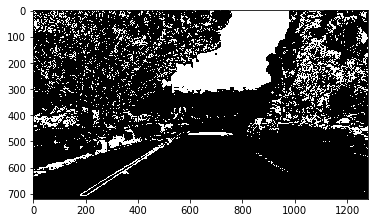

In [5]:
import binary

# Color space
hls = binary.hls_select(undistort, ch_filter=2, thresh=(90, 190))
plt.imshow(hls, cmap='gray')

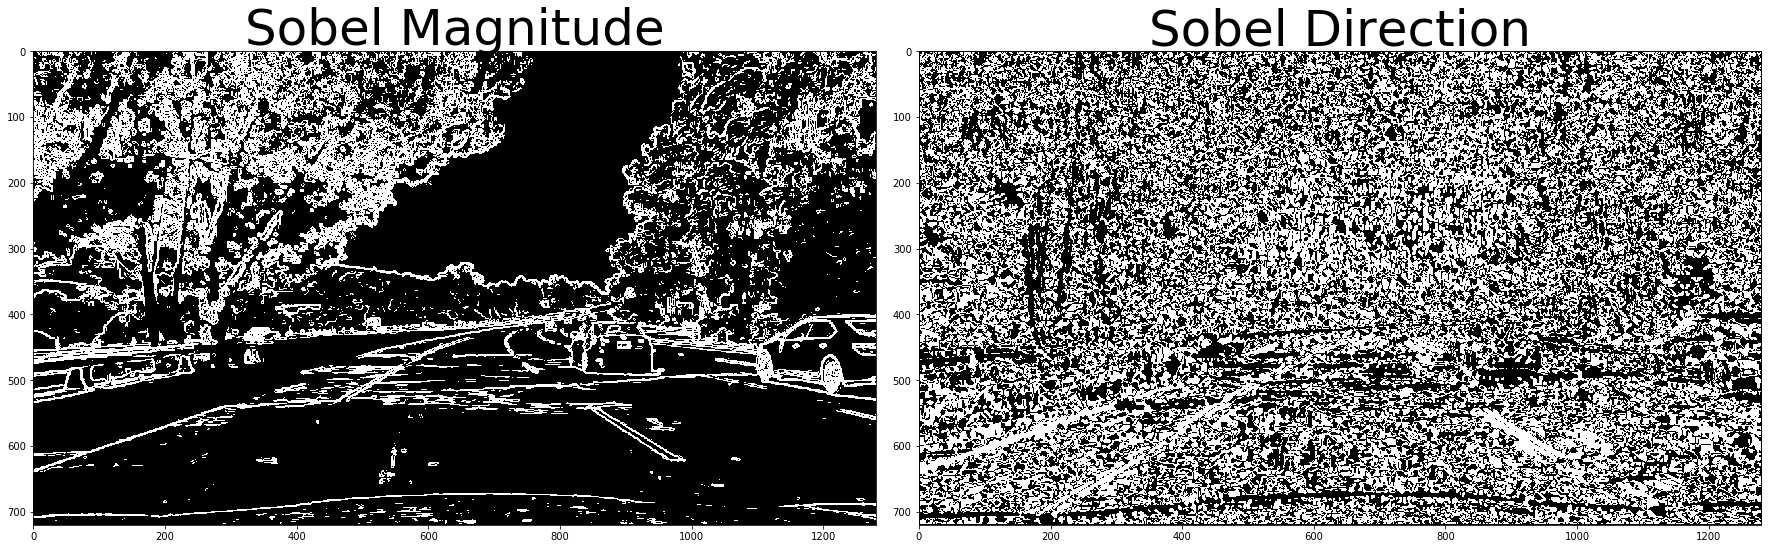

In [6]:
# Sobel

# Magnitude
mag = binary.mag_thresh(undistort, thresh=(20, 255))

# Direction
direction = binary.dir_thresh(undistort, thresh=(0.6, 1.4), kernel=15)

double_plt(
    image_1=mag, title_1='Sobel Magnitude',
    image_2=direction, title_2='Sobel Direction'
)

Here is the code to combine the binaries. This is also implemented is in `run.py`.

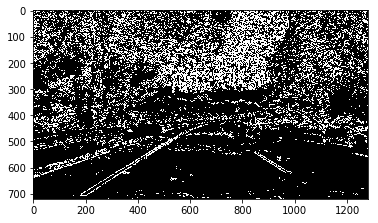

In [7]:
import numpy as np

combined = np.zeros_like(hls)
combined[
    ((hls == 1) & (direction == 1)) | 
    ((direction == 1) & (mag == 1)) | 
    ((hls == 1) & (mag == 1))
] = 1

plt.imshow(combined, cmap='gray')

### 3. Perspective Transform

The first step to performing the perspective transform was to find the source and destination points.

The process was the most manual part of the assignment.  I started with an approximation point, and basically used trial and error to find the right combinations. I then validated the transform using one of the straight line images.

The end result, along with the functions to perform the transform are in `transform.py`.

Source pts:
[[  507.   500.]
 [  792.   500.]
 [  150.   720.]
 [ 1200.   720.]]

Destination pts:
[[  150.   300.]
 [ 1200.   300.]
 [  150.   720.]
 [ 1200.   720.]]



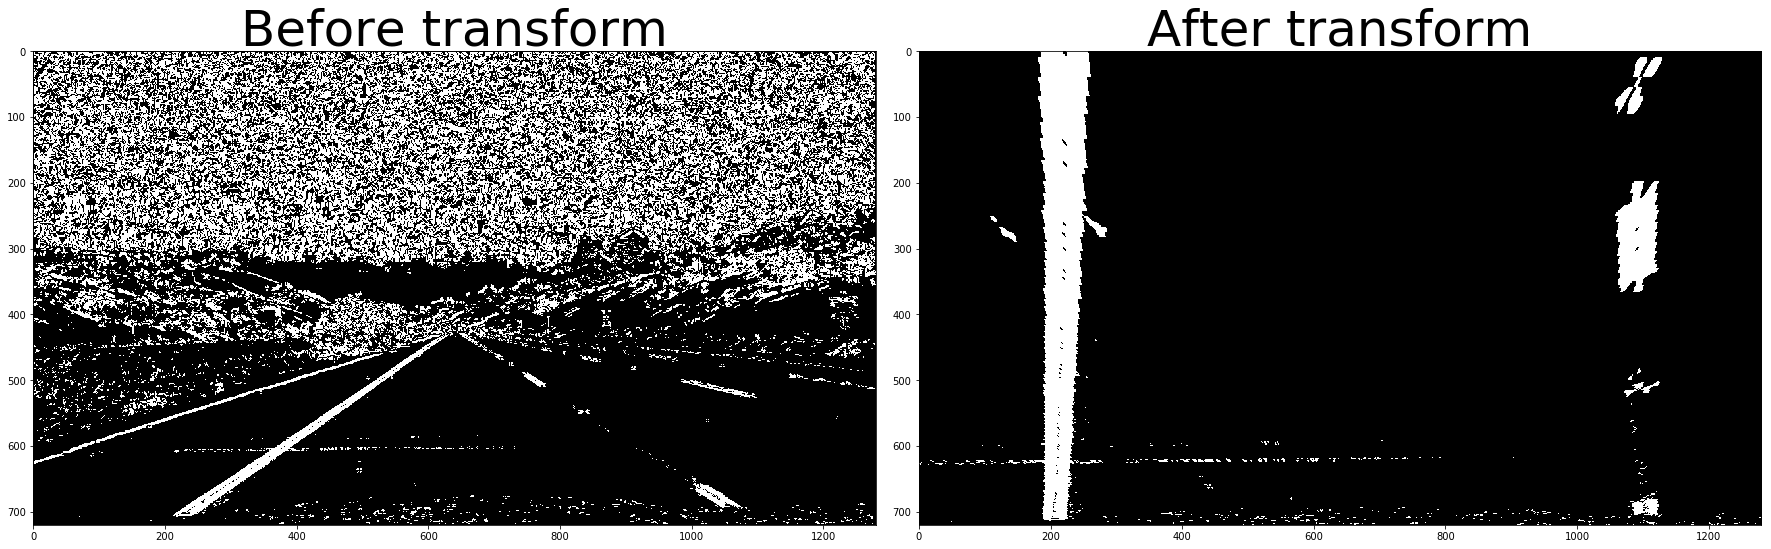

In [8]:
import run
import transform

# Load and undistort straight line image
straight_line = cv2.imread('./test_images/straight_lines1.jpg')
undistort = calibrate.undistort(straight_line, mtx, dist)

# Shortcut to apply the above filters
binary = run.apply_filters(undistort)

# Perspective transform
warped = transform.transform(
    binary, 
    src=transform.SOURCE,
    dst=transform.DEST
)

# Visualize
print('Source pts:\n{}\n'.format(transform.SOURCE))
print('Destination pts:\n{}\n'.format(transform.DEST))

double_plt(
    image_1=binary, title_1='Before transform',
    image_2=warped, title_2='After transform'
)

### 4. Lane fitting

To fit the lane lines with a polynomial, I used the histogram method to boostrap and the sliding window method to identify the subsequent parts of the lane.

Once the lane points are identified, they are fitted to a 2nd order polynomial function to summarize the lanes.

The code for this section can be found under `lanes/histogram.py`.

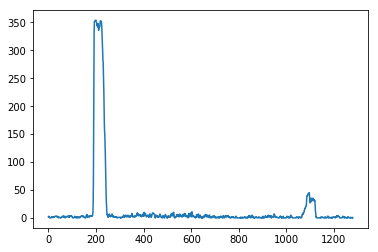

In [9]:
from lanes import histogram

# Identifying initial points with histogram
hist = histogram.histogram(warped)
plt.plot(hist)

The lanes can be clearly identified in this example.

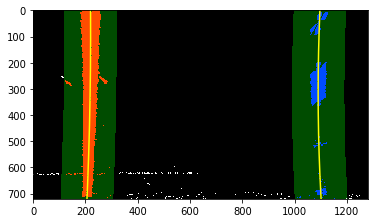

In [10]:
# Perform sliding window search
sw = histogram.SlidingWindow(warped)
sw.search()

# Visualize results
sw.visualize()

### 5. Calculating Curvature & Center

I calculated the curvature of the lanes in ft using the warped image. To do this, I initially approximated the pixel-to-ft conversion comparing known measurements of lanes (in ft) with actual measurements from images (in px). The resulting ratio used for subsequent calculations was:

* 10 ft / 200 y px
* 12 ft / 800 x px

I then recalculated fit lines with the new ratios to get the lane radiuses. See results (in ft) below.

In [11]:
sw.curvature_ft()

(2390.4797089811586, 1222.0457566638991)

To get the center of the car in relation to the lane (in ft), I subtracted the frame's x-center by the lane's x-center, and multipled that by 12 ft / 800 x px ratio above.

In [12]:
sw.center_offset()

2.888563653211988

The code for both curvature and center offset are in `lanes/histogram.py`.

### 6. Unwarping Lanes

To unwarp the lanes back onto the original image, I first get the left, and right lanes from the search in (4). 

I then filled in the space between the identified lane lines with an easily identifiable color (green). 

Lastly, I used the same perspective transform function as in (3), but with the source and destination points reversed.

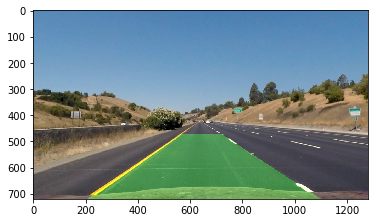

In [13]:
# Unwarping lanes
result = transform.unwarp_lane(
    warped,
    orig_img=cv2.cvtColor(undistort, cv2.COLOR_BGR2RGB),
    
    src=transform.SOURCE,  # the function will reverse these
    dst=transform.DEST,
    
    plot_y=sw.plot_y,
    left_x=sw.left_x,
    right_x=sw.right_x
)
plt.imshow(result, cmap='gray')

## Pipeline (Video)

The final output can be viewed below, or by opening the file located at `./processed_project_video.mp4`.

In [14]:
%%HTML

<video alt="output" style="width: 100%;" controls>
    <source src="./processed_project_video.mp4" type="video/mp4" />
</video>

## Discussion

The pipeline does well for the most part, but there are several main areas we can improve on.

**1) Lane length is short**

I tried moving my source and destination points higher up (lower `Y`) in the perspective transform, but had a hard time getting it right. The transformations often warped beyond recognition if I tried moving up higher, likely because the `X` values start to converge in the source points.

**2) Lanes lines still jitter**

This is especially true of the right lane, and is an issue I had even in Problem 1 (Basic Lane Finding).

To resolve this, I'd probably use the `Line` class suggested in the course to keep track of recent detections, 

**3) Pipeline fails on shadows**

If you look at frame 41.88 (see below), we can see that lane detection fails when there are shadows. What likely happens is that the shadow introduces too much noise into the filtered image, and messes up the histogram. As a result, the sliding window search starts with a bad initial point, and the subsequent lane fit is wrong.

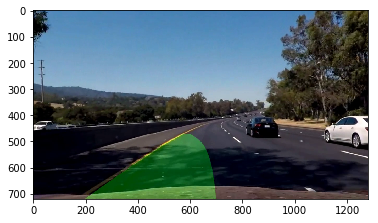

In [15]:
from moviepy.editor import VideoFileClip

clip = VideoFileClip('./processed_project_video.mp4')
clip_image = clip.get_frame(41.88)

plt.imshow(clip_image, cmap='gray')

We can also solve this part by using the `Line` class to track previous detections. We can pass those previous detections in as starting points for the sliding window search in later frames, and throw away anomalous detections like the one above.

**4) Lane curvature is non-zero for straight lines**

We can see this both from the image in section (4) above and in the curvature numbers returned in section (5). This is possibly due to camera calibration issues, and I'd try playing with different combination of calibration images in the future.